# Introduction

In our modeling efforts, time-related features have been shown to be very important. One problem with time-related features is the 'cuts' that happen, e.g. between 11PM and 12AM, even though these times are close. One method to deal with this, is to encode the time-features as cyclical features. In this notebook, we will build these features. 

# Load data
## Imports

In [7]:
import pandas as pd
import passenger_pred.load as ppl
import passenger_pred.preprocess as ppp
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import math

## Data

In [2]:
B6_DIR = "../data/B6/"

df_b6 = pd.read_csv(B6_DIR + "B6_20211028_20211121.csv")
df_b6.shape

(909698, 24)

In [3]:
df_b6 = ppp.add_uid(df_b6)
df_b6 = ppp.remove_duplicate_stops(df_b6)
df_b6 = ppp.add_time_features(df_b6)

In [4]:
df_b6 = df_b6[df_b6.passenger_count.notna()]
df_b6 = df_b6[df_b6.passenger_count != "None"]
df_b6.shape

(356380, 29)

In [5]:
df_b6['next_stop'] = pd.Categorical(df_b6.next_stop_id, ordered=False)
df_b6['next_stop'] = df_b6['next_stop'].cat.codes
df_b6.shape

(356380, 30)

# Add cyclical features
We focus on three features that we currently have included:
- `hour`
- `day`
- `dow`

First, we normalize values to range from `0` to `2pi`. Then, we apply `cos`. 

In [15]:
df_b6["hour_norm"] = 2 * math.pi * df_b6["hour"] / df_b6["hour"].max()

In [16]:
df_b6["cos_hour"] = np.cos(df_b6["hour_norm"])

<AxesSubplot:>

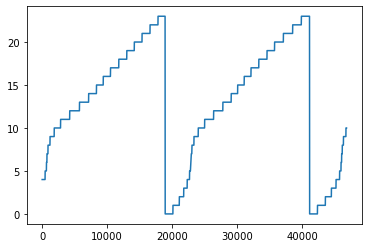

In [17]:
df_b6[:30000].hour.plot()

<AxesSubplot:>

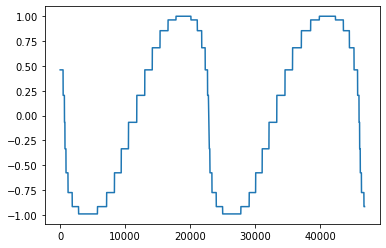

In [18]:
df_b6[:30000].cos_hour.plot()

That's the result we were looking for! Now let's repeat for `dow` and `day`

In [137]:
def add_cycl_var(df, var_name, cos=True, sin=False):
    norm = 2 * math.pi * df[var_name] / df[var_name].max()
    if cos:
        df["cos_" + var_name] = np.cos(norm)
    if sin:
        df["sin_" + var_name] = np.sin(norm)
    return df

def add_cycl_features(df, feature_names=['hour', 'day', 'dow'], cos=True, sin=False):
    for feature in feature_names:
        df = add_cycl_var(df, feature, cos, sin)
    return df

In [22]:
df_b6 = add_cycl_var(df_b6, "day")
df_b6.shape

(356380, 33)

<AxesSubplot:>

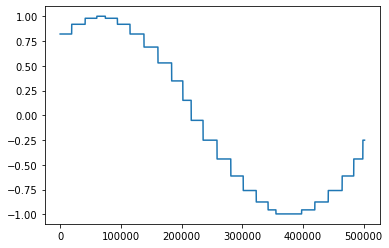

In [26]:
df_b6[:1000000].cos_day.plot()

In [27]:
df_b6 = add_cycl_var(df_b6, 'dow')
df_b6.shape

(356380, 34)

<AxesSubplot:>

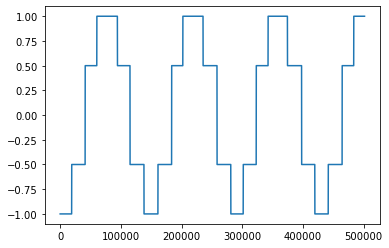

In [29]:
df_b6[:1000000].cos_dow.plot()

# Analysize model impact
We are interested in seeing whether adding these features improves our model.

In [35]:
df_b6['passenger_count'] = df_b6.passenger_count.astype("int")

In [36]:
df_test = df_b6[
    (df_b6.day > 15) &
    (df_b6.day < 23)
]

df_train = df_b6[~df_b6.index.isin(df_test.index)]

(df_train.shape, df_test.shape)

((259527, 34), (96853, 34))

In [37]:
df_train, df_test = ppp.add_averages(df_train, df_test)

## Base model

In [51]:
base_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
]

X_train_base = df_train[base_train_columns]
y_train_base = df_train.passenger_count

X_test_base = df_test[base_train_columns]
y_test_base = df_test.passenger_count

X_train_base.shape, y_train_base.shape, X_test_base.shape, y_test_base.shape

((259527, 7), (259527,), (96853, 7), (96853,))

In [131]:
regr_base = XGBRegressor(learning_rate=0.05, max_depth=5, objective='reg:gamma', n_estimators=120)

eval_set_base = [(X_train_base, y_train_base), (X_test_base, y_test_base)]

regr_base.fit(X=X_train_base, y=y_train_base, eval_metric=["rmsle", "logloss"], eval_set=eval_set_base, verbose=True)

[0]	validation_0-rmsle:2.06502	validation_0-logloss:-0.54010	validation_1-rmsle:2.08702	validation_1-logloss:-0.57294
[1]	validation_0-rmsle:2.04983	validation_0-logloss:-1.83563	validation_1-rmsle:2.07185	validation_1-logloss:-1.90287
[2]	validation_0-rmsle:2.03423	validation_0-logloss:-3.20413	validation_1-rmsle:2.05627	validation_1-logloss:-3.30761
[3]	validation_0-rmsle:2.01820	validation_0-logloss:-4.65925	validation_1-rmsle:2.04027	validation_1-logloss:-4.80106
[4]	validation_0-rmsle:2.00176	validation_0-logloss:-6.21859	validation_1-rmsle:2.02386	validation_1-logloss:-6.40133
[5]	validation_0-rmsle:1.98491	validation_0-logloss:-7.90569	validation_1-rmsle:2.00703	validation_1-logloss:-8.13244
[6]	validation_0-rmsle:1.96766	validation_0-logloss:-9.75296	validation_1-rmsle:1.98981	validation_1-logloss:-10.02746
[7]	validation_0-rmsle:1.94999	validation_0-logloss:-11.80615	validation_1-rmsle:1.97217	validation_1-logloss:-12.13343
[8]	validation_0-rmsle:1.93193	validation_0-logloss:-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=120, n_jobs=16,
             num_parallel_tree=1, objective='reg:gamma', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [132]:
y_pred_base = regr_base.predict(X_test_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)
round(mae_base, 3)

7.166

In [166]:
time_features = 0

for title, val in zip(base_train_columns, regr_base.feature_importances_):
    print(title, round(val, 3))
    if ('hour' in title) or ('day' in title) or ('dow' in title):
        time_features += val

print("Time features", round(time_features, 3))

direction 0.061
next_stop 0.079
lat 0.25
lon 0.303
hour 0.201
day 0.04
dow 0.066
Time features 0.307


## Model with cyclical features only

In [60]:
cycl_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "cos_hour",
    "cos_day",
    "cos_dow",
]

X_train_cycl = df_train[cycl_train_columns]
y_train_cycl = df_train.passenger_count

X_test_cycl = df_test[cycl_train_columns]
y_test_cycl = df_test.passenger_count

X_train_cycl.shape, y_train_cycl.shape, X_test_cycl.shape, y_test_cycl.shape

((259527, 7), (259527,), (96853, 7), (96853,))

In [178]:
regr_cycl = XGBRegressor(learning_rate=0.05, max_depth=5, objective='reg:gamma', n_estimators=300)

eval_set_cycl = [(X_train_cycl, y_train_cycl), (X_test_cycl, y_test_cycl)]

regr_cycl.fit(X=X_train_cycl, y=y_train_cycl, eval_metric=["rmsle", "mae"], eval_set=eval_set_cycl, verbose=True)

[0]	validation_0-rmsle:2.06499	validation_0-mae:12.48900	validation_1-rmsle:2.08697	validation_1-mae:12.84079
[1]	validation_0-rmsle:2.04979	validation_0-mae:12.46650	validation_1-rmsle:2.07177	validation_1-mae:12.81477
[2]	validation_0-rmsle:2.03414	validation_0-mae:12.43778	validation_1-rmsle:2.05614	validation_1-mae:12.78771
[3]	validation_0-rmsle:2.01809	validation_0-mae:12.40917	validation_1-rmsle:2.04008	validation_1-mae:12.76011
[4]	validation_0-rmsle:2.00162	validation_0-mae:12.38043	validation_1-rmsle:2.02362	validation_1-mae:12.73087
[5]	validation_0-rmsle:1.98474	validation_0-mae:12.34997	validation_1-rmsle:2.00674	validation_1-mae:12.70053
[6]	validation_0-rmsle:1.96746	validation_0-mae:12.31785	validation_1-rmsle:1.98945	validation_1-mae:12.66817
[7]	validation_0-rmsle:1.94975	validation_0-mae:12.28451	validation_1-rmsle:1.97175	validation_1-mae:12.63471
[8]	validation_0-rmsle:1.93166	validation_0-mae:12.25060	validation_1-rmsle:1.95366	validation_1-mae:12.60002
[9]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, objective='reg:gamma', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [179]:
y_pred_cycl = regr_cycl.predict(X_test_cycl)
mae_cycl = mean_absolute_error(y_test_cycl, y_pred_cycl)
round(mae_cycl, 3)

7.961

This did not improve performance. 

In [180]:
time_features = 0

for title, val in zip(cycl_train_columns, regr_cycl.feature_importances_):
    print(title, round(val, 3))
    if ('hour' in title) or ('day' in title) or ('dow' in title):
        time_features += val

print("Time features", round(time_features, 3))

direction 0.09
next_stop 0.071
lat 0.303
lon 0.186
cos_hour 0.129
cos_day 0.111
cos_dow 0.109
Time features 0.349


## Model with both regular and cyclical features

In [69]:
all_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "cos_hour",
    "cos_day",
    "cos_dow",
]

X_train_all = df_train[all_train_columns]
y_train_all = df_train.passenger_count

X_test_all = df_test[all_train_columns]
y_test_all = df_test.passenger_count

X_train_all.shape, y_train_all.shape, X_test_all.shape, y_test_all.shape

((259527, 10), (259527,), (96853, 10), (96853,))

In [94]:
def root_mean_squared_error(y_pred, dtrain):
        y_true = dtrain.get_label()
        return "rmsle", np.abs(math.sqrt(math.mean(math.square(y_pred - y_true), axis=-1)))

In [118]:
regr_all = XGBRegressor(learning_rate=0.1, max_depth=5, objective='reg:gamma', n_estimators=1000)

eval_set_all = [(X_train_all, y_train_all), (X_test_all, y_test_all)]

regr_all.fit(
    X=X_train_all, 
    y=y_train_all, 
    eval_metric=["rmsle", "mae"], 
    eval_set=eval_set_all, 
    verbose=True
)

[0]	validation_0-rmsle:2.04980	validation_0-mae:12.46652	validation_1-rmsle:2.07181	validation_1-mae:12.81499
[1]	validation_0-rmsle:2.01814	validation_0-mae:12.40974	validation_1-rmsle:2.04017	validation_1-mae:12.76045
[2]	validation_0-rmsle:1.98480	validation_0-mae:12.35017	validation_1-rmsle:2.00686	validation_1-mae:12.70115
[3]	validation_0-rmsle:1.94983	validation_0-mae:12.28628	validation_1-rmsle:1.97192	validation_1-mae:12.63642
[4]	validation_0-rmsle:1.91324	validation_0-mae:12.21511	validation_1-rmsle:1.93536	validation_1-mae:12.56543
[5]	validation_0-rmsle:1.87511	validation_0-mae:12.13752	validation_1-rmsle:1.89727	validation_1-mae:12.48829
[6]	validation_0-rmsle:1.83551	validation_0-mae:12.05321	validation_1-rmsle:1.85770	validation_1-mae:12.40442
[7]	validation_0-rmsle:1.79450	validation_0-mae:11.96613	validation_1-rmsle:1.81676	validation_1-mae:12.31759
[8]	validation_0-rmsle:1.75222	validation_0-mae:11.87903	validation_1-rmsle:1.77450	validation_1-mae:12.22928
[9]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, objective='reg:gamma', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [119]:
y_pred_all = regr_all.predict(X_test_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
round(mae_all, 3)

6.789

In [164]:
time_features = 0

for title, val in zip(all_train_columns, regr_all.feature_importances_):
    print(title, round(val, 3))
    if ('hour' in title) or ('day' in title) or ('dow' in title):
        time_features += val

print("Time features", round(time_features, 3))

direction 0.111
next_stop 0.07
lat 0.141
lon 0.122
hour 0.233
day 0.041
dow 0.124
cos_hour 0.061
cos_day 0.055
cos_dow 0.043
Time features 0.556


That did slightly improve our performance!

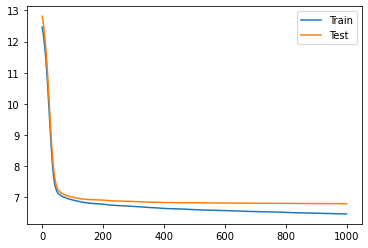

In [121]:
results = regr_all.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

In [134]:
round((1 - mae_all / mae_base) * 100, 2)

5.26

## Also adding sin

In one last attempt, we'll also include the sin of these features

In [138]:
df_b6 = add_cycl_features(df_b6, cos=False, sin=True)

In [139]:
df_test = df_b6[
    (df_b6.day > 15) &
    (df_b6.day < 23)
]

df_train = df_b6[~df_b6.index.isin(df_test.index)]

(df_train.shape, df_test.shape)

((259527, 37), (96853, 37))

In [140]:
sin_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "cos_hour",
    "cos_day",
    "cos_dow",
    "sin_hour",
    "sin_day",
    "sin_dow",
]

X_train_sin = df_train[sin_train_columns]
y_train_sin = df_train.passenger_count

X_test_sin = df_test[sin_train_columns]
y_test_sin = df_test.passenger_count

X_train_sin.shape, y_train_sin.shape, X_test_sin.shape, y_test_sin.shape

((259527, 13), (259527,), (96853, 13), (96853,))

In [155]:
regr_sin = XGBRegressor(learning_rate=0.1, max_depth=6, objective='reg:gamma', n_estimators=700)

eval_set_sin = [(X_train_sin, y_train_sin), (X_test_sin, y_test_sin)]

regr_sin.fit(
    X=X_train_sin, 
    y=y_train_sin, 
    eval_metric=["rmsle", "mae"], 
    eval_set=eval_set_sin, 
    verbose=True
)

[0]	validation_0-rmsle:2.04981	validation_0-mae:12.46695	validation_1-rmsle:2.07181	validation_1-mae:12.81527
[1]	validation_0-rmsle:2.01816	validation_0-mae:12.40961	validation_1-rmsle:2.04017	validation_1-mae:12.76048
[2]	validation_0-rmsle:1.98484	validation_0-mae:12.35107	validation_1-rmsle:2.00688	validation_1-mae:12.70122
[3]	validation_0-rmsle:1.94987	validation_0-mae:12.28622	validation_1-rmsle:1.97194	validation_1-mae:12.63626
[4]	validation_0-rmsle:1.91333	validation_0-mae:12.21539	validation_1-rmsle:1.93540	validation_1-mae:12.56559
[5]	validation_0-rmsle:1.87521	validation_0-mae:12.13821	validation_1-rmsle:1.89733	validation_1-mae:12.48853
[6]	validation_0-rmsle:1.83561	validation_0-mae:12.05439	validation_1-rmsle:1.85776	validation_1-mae:12.40442
[7]	validation_0-rmsle:1.79461	validation_0-mae:11.96799	validation_1-rmsle:1.81682	validation_1-mae:12.31795
[8]	validation_0-rmsle:1.75237	validation_0-mae:11.87982	validation_1-rmsle:1.77461	validation_1-mae:12.22958
[9]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=16,
             num_parallel_tree=1, objective='reg:gamma', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [156]:
y_pred_sin = regr_sin.predict(X_test_sin)
mae_sin = mean_absolute_error(y_test_sin, y_pred_sin)
round(mae_sin, 3)

6.776

In [157]:
round((1 - mae_sin / mae_base) * 100, 2)

5.45

In [163]:
time_features = 0

for title, val in zip(sin_train_columns, regr_sin.feature_importances_):
    print(title, round(val, 3))
    if ('hour' in title) or ('day' in title) or ('dow' in title):
        time_features += val

print("Time features", round(time_features, 3))

direction 0.083
next_stop 0.064
lat 0.111
lon 0.109
hour 0.196
day 0.03
dow 0.1
cos_hour 0.058
cos_day 0.061
cos_dow 0.055
sin_hour 0.073
sin_day 0.032
sin_dow 0.03
Time features 0.633


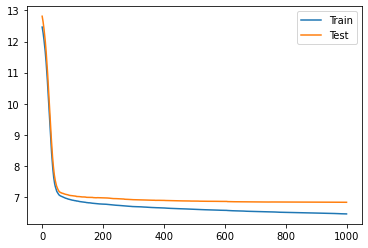

In [147]:
results = regr_sin.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()